In [1]:
# Import libraries 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import glob 
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Data Augmentation
Lets add augmented data to our Dataset Before proceeding lets understand some of the datasets

## Augmentation methods

In [2]:
"""
    Adding White Noise.
"""

def noise(data):
    noise_amp = 0.05*np.random.uniform()*np.amax(data)   # more noise reduce the value to 0.5
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    

In [3]:
"""
    Random Shifting.
"""

def shift(data):
    s_range = int(np.random.uniform(low=-5, high = 5)*1000)  #default at 500
    return np.roll(data, s_range)

In [4]:
"""
    Streching the Sound. Note that this expands the dataset slightly
"""

def stretch(data, rate=0.8):
    data = librosa.effects.time_stretch(data, rate)
    return data

In [5]:
"""
    Pitch Tuning.
"""

def pitch(data, sample_rate):
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data

In [6]:
"""
    Random Value Change.
"""

def dyn_change(data):
    dyn_change = np.random.uniform(low=-0.5 ,high=3)  # default low = 1.5, high = 3
    return (data * dyn_change)

In [7]:
"""
    speed and Pitch Tuning.
"""

def speedNpitch(data):
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.2  / length_change # try changing 1.0 to 2.0 ... =D
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data

In [8]:
os.listdir('Data/genres_original')

['metal',
 'blues',
 'country',
 'reggae',
 'rock',
 'hiphop',
 'classical',
 'pop',
 'disco',
 'jazz']

In [9]:
Class = ['country',
 'jazz',
 'classical',
 'pop',
 'blues',
 'hiphop',
 'disco',
 'reggae',
 'rock',
 'metal']

In [10]:
Class.sort()

In [11]:
Class

['blues',
 'classical',
 'country',
 'disco',
 'hiphop',
 'jazz',
 'metal',
 'pop',
 'reggae',
 'rock']

# Load the dataset

In [12]:
ref = pd.DataFrame()

labels_list =[]
path_list = []

for i in Class:
    filepath = os.path.join('Data/genres_original',i)
    label  = i
    for audio_name in os.listdir(filepath):
        audiopath = os.path.join(filepath , audio_name)
        labels_list.append(label)
        path_list.append(audiopath)
    

In [13]:
ref["labels"] = labels_list
ref["path"] = path_list

In [14]:
ref.head(200)

,labels,path
0,blues,Data/genres_original/blues/blues.00011.wav
1,blues,Data/genres_original/blues/blues.00038.wav
2,blues,Data/genres_original/blues/blues.00045.wav
3,blues,Data/genres_original/blues/blues.00076.wav
4,blues,Data/genres_original/blues/blues.00012.wav
...,...,...
195,classical,Data/genres_original/classical/classical.00000...
196,classical,Data/genres_original/classical/classical.00020...
197,classical,Data/genres_original/classical/classical.00013...
198,classical,Data/genres_original/classical/classical.00052...


In [15]:
ref.shape

(1000, 2)

In [16]:
ref["path"][0]

'Data/genres_original/blues/blues.00011.wav'

# Feature Extraction

In [17]:
from tqdm import tqdm

In [18]:
def features(data, sample_rate) :
    mfccs_features = librosa.feature.mfcc(y=data,sr=sample_rate,n_mfcc =39)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate), axis=1)
    
    S = librosa.feature.melspectrogram(y=data, sr=sample_rate, power=1)
    melspectogram = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate),axis=1) # (128,)
    
    combined_features = np.append(mfccs_scaled_features, chroma_stft )
    combined_features = np.append(combined_features, melspectogram )
    
    return combined_features

In [20]:
df = pd.DataFrame(columns=['feature', "music_label"])

# loop feature extraction over the entire dataset
counter=0
for index,path in tqdm(enumerate(ref.path)):
    try:
        X, sample_rate = librosa.load(path, res_type='kaiser_fast')
        
        #original data
        data = features(X,sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        # add noise
        noised_data = noise(X) ;
        data = features(noised_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        #shift data
        shifted_data = shift(X)
        data = features(shifted_data,sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1  
        
        #stretch data
        stretched_data = stretch(X)
        data = features(stretched_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1 
        
        # pitch
        pitched_data = pitch(X,sample_rate)
        data = features(pitched_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
        
        #random change 
        random_changed_data = dyn_change(X)
        data = features(random_changed_data, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
        
        #speed and Pitch Tuning.
        newX = speedNpitch(X)
        data = features(newX, sample_rate)
        df.loc[counter] = [data,ref.labels[index]]
        counter=counter+1
                
    except :
        pass

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

1000it [56:29,  3.39s/it]


6993


,feature,music_label
0,"[-287.92374, 124.01875, 5.4698925, 33.65741, 1...",blues
1,"[-227.34443940779462, 70.79010150007255, 26.16...",blues
2,"[-287.97357, 124.20824, 5.354764, 33.79136, 0....",blues
3,"[-319.8637, 116.84348, 8.3179865, 31.60435, 1....",blues
4,"[-309.605266784981, 108.94692472940363, 11.101...",blues


In [21]:
import pickle
pickle.dump(df, open("augmented_data_mfccs_with_extra_features", "wb"))

In [23]:
import pickle
df = pickle.load(open("augmented_data_mfccs_with_extra_features", "rb"))

In [24]:
final_df = pd.DataFrame()
final_df = pd.concat([final_df,pd.DataFrame(df["music_label"]),pd.DataFrame(df['feature'].values.tolist())],axis=1)


In [25]:
final_df.head()

,music_label,0,1,2,3,4,5,6,7,8,...,169,170,171,172,173,174,175,176,177,178
0,blues,-287.923737,124.018753,5.469893,33.657410,1.095497,14.705335,-4.877008,8.670525,0.785405,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
1,blues,-227.344439,70.790102,26.163911,20.155726,8.932708,8.850713,2.583260,3.851163,3.607360,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
2,blues,-287.973572,124.208237,5.354764,33.791359,0.991442,14.802068,-4.916224,8.728582,0.760979,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
3,blues,-319.863708,116.843483,8.317986,31.604349,1.739211,14.198795,-4.266875,8.528231,1.661379,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
4,blues,-309.605267,108.946925,11.101800,24.063488,2.000294,9.116265,-3.061725,7.717573,-1.709441,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08


In [26]:
# replace NA with 0
final_df=final_df.fillna(0)
print(final_df.shape)
final_df[:5]


(6993, 180)


,music_label,0,1,2,3,4,5,6,7,8,...,169,170,171,172,173,174,175,176,177,178
0,blues,-287.923737,124.018753,5.469893,33.657410,1.095497,14.705335,-4.877008,8.670525,0.785405,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
1,blues,-227.344439,70.790102,26.163911,20.155726,8.932708,8.850713,2.583260,3.851163,3.607360,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
2,blues,-287.973572,124.208237,5.354764,33.791359,0.991442,14.802068,-4.916224,8.728582,0.760979,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
3,blues,-319.863708,116.843483,8.317986,31.604349,1.739211,14.198795,-4.266875,8.528231,1.661379,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08
4,blues,-309.605267,108.946925,11.101800,24.063488,2.000294,9.116265,-3.061725,7.717573,-1.709441,...,0.000548,0.000339,0.000141,0.000058,0.000023,0.000005,6.271545e-07,1.320735e-07,4.301605e-08,3.802009e-08


In [27]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['music_label'],axis=1)
                                                    , df.music_label
                                                    , test_size=0.2
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

,0,1,2,3,4,5,6,7,8,9,...,169,170,171,172,173,174,175,176,177,178
3161,-157.618739,65.953828,-2.280114,34.804125,6.267474,30.151325,-2.287476,18.075128,-3.649950,14.850137,...,0.145446,0.081638,0.069940,0.054204,0.043256,4.089001e-02,5.001010e-02,4.339468e-02,3.628050e-02,4.139304e-02
3961,-259.516144,21.412062,9.847793,18.834452,2.680288,2.541264,0.582706,1.121911,-1.128281,0.504592,...,0.030090,0.047854,0.035770,0.034922,0.018610,3.813761e-02,3.155419e-02,1.392059e-02,1.810990e-02,9.689694e-03
3248,-114.013184,110.141655,17.895763,37.946213,27.990702,1.409508,15.558240,1.416771,7.350121,-3.328758,...,0.025896,0.025429,0.030265,0.034315,0.046821,4.065090e-02,3.664780e-02,4.557841e-02,4.206940e-02,4.207734e-02
149,-30.058479,103.750305,-19.732666,56.439526,-12.698974,20.207527,-17.332209,16.319714,-18.451443,8.934578,...,0.023747,0.015967,0.011671,0.005690,0.003625,2.064497e-03,1.464732e-03,1.319549e-03,1.304051e-03,1.301074e-03
4667,50.782482,71.188530,-22.356430,60.283909,-18.555540,27.631037,-12.416349,16.956556,-8.735030,17.874517,...,0.238045,0.127725,0.088848,0.071831,0.046868,4.762676e-02,5.118610e-02,4.737019e-02,3.889201e-02,3.582918e-02
3869,-150.359833,174.379013,-19.723122,47.348385,-1.943281,6.657073,-1.088486,-5.514929,-13.738750,-3.710453,...,0.000026,0.000013,0.000007,0.000003,0.000002,9.520724e-07,7.683512e-07,6.971933e-07,6.596509e-07,6.363109e-07
453,-25.088150,72.082497,-7.753568,49.242702,-32.715286,21.595116,-27.360632,14.991587,-10.249061,12.419811,...,0.038544,0.021234,0.007405,0.002327,0.000858,2.054170e-04,5.478123e-05,5.911698e-06,1.601389e-06,1.264372e-06
3282,-207.496231,57.999439,-7.574059,23.033880,-2.356360,10.179043,0.027026,8.796794,0.603316,3.468517,...,0.010721,0.008462,0.007749,0.008340,0.006284,5.065486e-03,4.349570e-03,3.618919e-03,2.624207e-03,2.164918e-03
1786,-161.734649,99.118387,19.439157,44.614089,8.994781,18.281020,0.495632,9.949340,-7.167540,5.522362,...,0.006925,0.004176,0.002196,0.000989,0.000352,8.935278e-05,1.701086e-05,2.033639e-06,2.474866e-07,1.222827e-07
2716,-133.819321,93.490356,-24.230862,61.447289,-22.856272,30.987030,-14.966417,20.237169,-9.300377,15.792407,...,0.004378,0.002578,0.001088,0.000500,0.000160,4.723364e-05,2.576632e-05,3.153013e-06,1.368074e-07,8.975054e-09


In [29]:
# # Lets do data normalization
# #Here we are using z-score normalization technique
# mean = np.mean(X_train, axis=0)
# std = np.std(X_train, axis=0)

# X_train = (X_train - mean)/std
# X_test = (X_test - mean)/std

# # Check the dataset now 
# X_train[150:160]

In [30]:
from keras.utils import np_utils, to_categorical
from sklearn.preprocessing import LabelEncoder
import pickle

In [31]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Label encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
#print(y_train[0:10])
#print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'mgc_label_encoder'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(5594, 179)
['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


In [32]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(5594, 179, 1)

In [33]:
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint


In [34]:
model = Sequential()
model.add(Conv1D(256, 4, padding='same',input_shape=(X_train.shape[1],1))) 
# X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(128, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(128, 4, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(4)))

model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Conv1D(64, 4, padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(10)) # Target class number
model.add(Activation('softmax'))

opt = keras.optimizers.Adam(lr=0.0001)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 179, 256)          1280      
_________________________________________________________________
activation (Activation)      (None, 179, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 179, 256)          262400    
_________________________________________________________________
batch_normalization (BatchNo (None, 179, 256)          1024      
_________________________________________________________________
activation_1 (Activation)    (None, 179, 256)          0         
_________________________________________________________________
dropout (Dropout)            (None, 179, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 44, 256)           0

In [35]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=32, epochs=40, validation_data=(X_test, y_test))

Epoch 1/40
175/175 [==============================] - 33s 169ms/step - loss: 2.3817 - accuracy: 0.1680 - val_loss: 1.9774 - val_accuracy: 0.3095
Epoch 2/40
175/175 [==============================] - 22s 125ms/step - loss: 2.0380 - accuracy: 0.2597 - val_loss: 1.8781 - val_accuracy: 0.3767
Epoch 3/40
175/175 [==============================] - 22s 124ms/step - loss: 1.9064 - accuracy: 0.3007 - val_loss: 1.7984 - val_accuracy: 0.3939
Epoch 4/40
175/175 [==============================] - 25s 143ms/step - loss: 1.7812 - accuracy: 0.3648 - val_loss: 1.6814 - val_accuracy: 0.4861
Epoch 5/40
175/175 [==============================] - 27s 152ms/step - loss: 1.6904 - accuracy: 0.3956 - val_loss: 1.6164 - val_accuracy: 0.4861
Epoch 6/40
175/175 [==============================] - 25s 143ms/step - loss: 1.6320 - accuracy: 0.4239 - val_loss: 1.5618 - val_accuracy: 0.4846
Epoch 7/40
175/175 [==============================] - 27s 152ms/step - loss: 1.5395 - accuracy: 0.4695 - val_loss: 1.4724 - val_ac

In [34]:
model.save("MGC_Models/music_genre_classificatiob_model_mfccs_with_extra_features.h5") #(mfccs+pcen+chroma)

In [35]:
score = model.evaluate(X_test, y_test, verbose=0)
score
print("Loss : {}  \nAccuracy : {} ".format(score[0], score[1]))

Loss : 0.40280550718307495  
Accuracy : 0.8727662563323975 


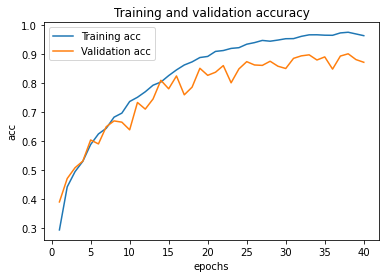

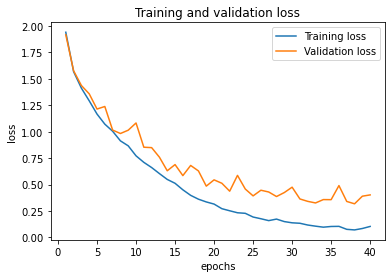

In [36]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.show()